# Imports

In [1]:
import cv2
import numpy as np
import time
import os
import matplotlib.pyplot as plt
import pandas as pd

# Constants
## For styling

In [107]:
colors = [(255,0,0), (127,0,255), (0,127,0), (0,127,255)]
line_padding = [0.7, 1.5,1.5,1.5]

font_scale = 1
text_position_cnt = (100, 100)
text_position_time = (100, 120)

output_folder_video = "../output/video"
output_folder_csv = "../output/csv"

## For algorithm tuning

In [3]:
# Are for optime
kernel = np.ones((5,5),np.uint8)
threshold_area_size = [80, 20, 10, 40]
video_path = "../IMG_7102.MOV"
frame_shift = 500
set_fps = 150 # I dont know if its work

video_name = "test_01_my_hand"

## Support functions

In [4]:
# Add text overlay into video frame
def add_text_to_frame(frame, text, position=(30, 30), font=cv2.FONT_HERSHEY_SIMPLEX, font_scale=0.2, color=(0, 255, 0), thickness=2):
    """
    Add text to a frame.

    Parameters:
    - frame (numpy.ndarray): Input frame.
    - text (str): Text to be added to the frame.
    - position (tuple): Position of the text (x, y).
    - font (int): Font type.
    - font_scale (float): Font scale.
    - color (tuple): Text color (B, G, R).
    - thickness (int): Text thickness.

    Returns:
    - numpy.ndarray: Frame with added text.
    """
    frame_with_text = frame.copy()
    cv2.putText(frame_with_text, text, position, font, font_scale, color, thickness)
    return frame_with_text

In [5]:
def calculate_angle(line1, line2):
    # Convert lines to numpy arrays
    line1 = np.array(line1)
    line2 = np.array(line2)

    # Calculate the vectors corresponding to the lines
    vector1 = line1[1] - line1[0]
    vector2 = line2[1] - line2[0]

    # Calculate the dot product and cross product of the vectors
    dot_product = np.dot(vector1, vector2)
    cross_product = np.cross(vector1, vector2)

    # Calculate the magnitudes of the vectors
    magnitude1 = np.linalg.norm(vector1)
    magnitude2 = np.linalg.norm(vector2)

    # Calculate the cosine of the angle between the vectors
    cosine_theta = dot_product / (magnitude1 * magnitude2)

    # Determine the sign of the dot product to determine the direction
    if dot_product > 0:
        angle_radians = np.arccos(cosine_theta)
        # Convert the angle to degrees
        angle_degrees = 180 - np.degrees(angle_radians)
        # Adjust angle for the cross product sign
        if cross_product < 0:
            angle_degrees = 360 - angle_degrees
    else:
        angle_radians = np.arccos(cosine_theta)
        # Convert the angle to degrees
        angle_degrees = np.degrees(angle_radians)

    return angle_degrees

In [6]:
def calculate_vector(point1, point2):
    return np.array(point2) - np.array(point1)

In [7]:
def segment_marker_by_color(frame_tmp):
    # Input must be a frame in the cielab color model from the OpenCV function

    # Extract color channels
    L_channel = frame_tmp[:, :, 0]
    a_channel = frame_tmp[:, :, 1]
    b_channel = frame_tmp[:, :, 2]

    # Color segmentation using NumPy array operations
    marker_blue = (a_channel > 140) & (a_channel < 170) & (b_channel > 160)
    marker_pink = (a_channel > 175) & (b_channel < 80)
    marker_green = (a_channel < 120) & (b_channel > 130)
    marker_yellow = (a_channel > 80) & (a_channel < 120) & (b_channel > 90) & (b_channel < 110)

    return marker_blue, marker_pink, marker_green, marker_yellow

In [8]:
def find_intersection(p1, p2, q1, q2):
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = q1
    x4, y4 = q2

    det = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
    if det != 0:
        px = int(((x1 * y2 - y1 * x2) * (x3 - x4) - (x1 - x2) * (x3 * y4 - y3 * x4)) / det)
        py = int(((x1 * y2 - y1 * x2) * (y3 - y4) - (y1 - y2) * (x3 * y4 - y3 * x4)) / det)
        return px, py
    else:
        return None

def calculate_distance(point1, point2):
    x1, y1 = point1
    x2, y2 = point2
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

In [203]:
def main_function(frame, swap):
    # Convert the input frame to the CIELAB color space
    cielab_frame = cv2.cvtColor(frame, cv2.COLOR_RGB2Lab)

    # Segment markers by color in the CIELAB color space
    marker_blue, marker_pink, marker_green, marker_yellow = segment_marker_by_color(cielab_frame)

    # Create a stack of masks for each color marker
    masks = np.stack([marker_blue, marker_pink, marker_green, marker_yellow], axis=0)

    # Define color names for visualization
    colors_name = ["blue", "pink", "green", "yellow"]

    # Initialize a list to store points per frame
    point_per_frame = []

    # Set the line padding value
    line_pad = 5  # Adjust this value as needed

    # Initialize the direction vector for the first line
    direction_vector_0_1 = None

    # Iterate over each color marker
    for mask, thr, color, color_name, direction_vector in zip(
            masks, threshold_area_size, colors, colors_name, [direction_vector_0_1, None, None, None]
    ):
        # Convert the mask to uint8
        mask = np.uint8(mask)

        # Find connected components in the mask
        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask)

        # Filter regions based on area threshold
        filtered_regions = [index for index, stat in enumerate(stats[1:]) if stat[4] >= thr]

        # Initialize a list to store points per mask
        point_per_mask = []

        # Iterate over filtered regions in the mask
        for idx, index in enumerate(filtered_regions):
            # Access region properties from the stats array
            left, top, width, height, area = stats[index + 1]

            # Calculate the centroid
            centroid_x, centroid_y = int(left + width / 2), int(top + height / 2)

            # Append the centroid to the list of points for the mask
            point_per_mask.append((centroid_x, centroid_y))

        # Visualize circles for each point in the mask
        for idx, point in enumerate(point_per_mask):
            cv2.circle(frame, (point[0], point[1]), radius=idx * 10, color=color, thickness=5)

        # Visualize circles for each point with increased radius
        for idx, point in enumerate(point_per_mask):
            cv2.circle(frame, (point[0], point[1]), radius=idx * 10 + 10, color=color, thickness=5)

        # If direction vector is not initialized, calculate it from the first two points
        if direction_vector is None:
            direction_vector = calculate_vector(point_per_mask[1], point_per_mask[0])

        # Calculate points for the line based on the direction vector and line padding
        point1 = (
            int(point_per_mask[1][0] - line_pad * direction_vector[0]),
            int(point_per_mask[1][1] - line_pad * direction_vector[1]),
        )
        point2 = (
            int(point_per_mask[0][0] + line_pad * direction_vector[0]),
            int(point_per_mask[0][1] + line_pad * direction_vector[1]),
        )

        # Visualize the line connecting the two points
        cv2.line(frame, point1, point2, color, 3)

        # Append the points for the current mask to the list of points per frame
        point_per_frame.append(point_per_mask)

    # Find the intersection point
    intersection_point_0 = find_intersection(point_per_frame[0][0], point_per_frame[0][1], point_per_frame[1][0], point_per_frame[1][1])
    intersection_point_1 = find_intersection(point_per_frame[1][0], point_per_frame[1][1], point_per_frame[2][0], point_per_frame[2][1])
    intersection_point_2 = find_intersection(point_per_frame[2][0], point_per_frame[2][1], point_per_frame[3][0], point_per_frame[3][1])

    # Here is calculated that tip point must be selected as intersections point
    if calculate_distance(point_per_frame[3][0], point_per_frame[0][0]) < calculate_distance(point_per_frame[3][0], point_per_frame[0][1]):
        trajectory_point_0 = point_per_frame[0][0]
    else:
        trajectory_point_0 = point_per_frame[0][1]

    if calculate_distance(point_per_frame[0][0], point_per_frame[1][0]) > calculate_distance(point_per_frame[0][0], point_per_frame[1][1]):
        trajectory_point_1 = point_per_frame[1][0]
    else:
        trajectory_point_1 = point_per_frame[1][1]



    if calculate_distance(point_per_frame[2][0], point_per_frame[3][0]) > calculate_distance(point_per_frame[2][0], point_per_frame[3][1]):
        trajectory_point_3 = point_per_frame[3][0]
    else:
        trajectory_point_3 = point_per_frame[3][1]

    if calculate_distance(point_per_frame[1][0], point_per_frame[2][0]) > calculate_distance(point_per_frame[1][0], point_per_frame[2][1]):
        trajectory_point_2 = point_per_frame[2][0]
    else:
        trajectory_point_2 = point_per_frame[2][1]

    # Draw the joint point
    cv2.circle(frame, trajectory_point_0, 10, (0, 0, 0), -1)
    cv2.circle(frame, trajectory_point_1, 10, (0, 0, 0), -1)
    cv2.circle(frame, trajectory_point_2, 10, (0, 0, 0), -1)
    cv2.circle(frame, trajectory_point_3, 10, (0, 0, 0), -1)


    # Draw the intersection point
    cv2.circle(frame, intersection_point_0, 3, (255, 255, 255), -1)
    cv2.circle(frame, intersection_point_1, 3, (255, 255, 255), -1)
    cv2.circle(frame, intersection_point_2, 3, (255, 255, 255), -1)


    # # Find the intersection point
    # intersection_point = find_intersection(point_per_frame[0][0], point_per_frame[0][1], point_per_frame[1][0], point_per_frame[1][1])
    #
    # # Draw the intersection point
    # if intersection_point:
    #     cv2.circle(frame, intersection_point, 10, (255, 255, 255), -1)

    # Calculate angles between consecutive lines
    angle_0 = calculate_angle(point_per_frame[0], point_per_frame[1])
    angle_1 = calculate_angle(point_per_frame[1], point_per_frame[2])
    angle_2 = calculate_angle(point_per_frame[2], point_per_frame[3])

    # Add text annotations to the frame with calculated angles
    frame = add_text_to_frame(frame, "ANGLE 0: {}".format(int(angle_0)), position=(1000, 810), font_scale=0.5, thickness=2, color=(255, 255, 0))
    frame = add_text_to_frame(frame, "ANGLE 1: {}".format(int(angle_1)), position=(1000, 830), font_scale=0.5, thickness=2, color=(255, 255, 0))
    frame = add_text_to_frame(frame, "ANGLE 2: {}".format(int(angle_2)), position=(1000, 850), font_scale=0.5, thickness=2, color=(255, 255, 0))
    return frame, angle_0, angle_1, angle_2, trajectory_point_0, trajectory_point_1, trajectory_point_2, trajectory_point_3


In [102]:

def store_video(frames, output_path, fps):


    # Function to store the video with updated frames
    fourcc = cv2.VideoWriter_fourcc(*'avc1')
    height, width, _ = frames[0].shape
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    for frame in frames:
        out.write(frame)

    out.release()

[ WARN:0@16214.617] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_562_cazh1h/croots/recipe/opencv-suite_1664548333142/work/modules/videoio/src/cap_gstreamer.cpp (2386) handleMessage OpenCV | GStreamer warning: your GStreamer installation is missing a required plugin
[ WARN:0@16214.618] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_562_cazh1h/croots/recipe/opencv-suite_1664548333142/work/modules/videoio/src/cap_gstreamer.cpp (2402) handleMessage OpenCV | GStreamer warning: Embedded video playback halted; module uridecodebin39 reported: Your GStreamer installation is missing a plug-in.
[ WARN:0@16214.618] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_562_cazh1h/croots/recipe/opencv-suite_1664548333142/work/modules/videoio/src/cap_gstreamer.cpp (1356) open OpenCV | GStreamer warning: unable to start pipeline
[ WARN:0@16214.618] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_562_cazh1h/croots/recipe/open

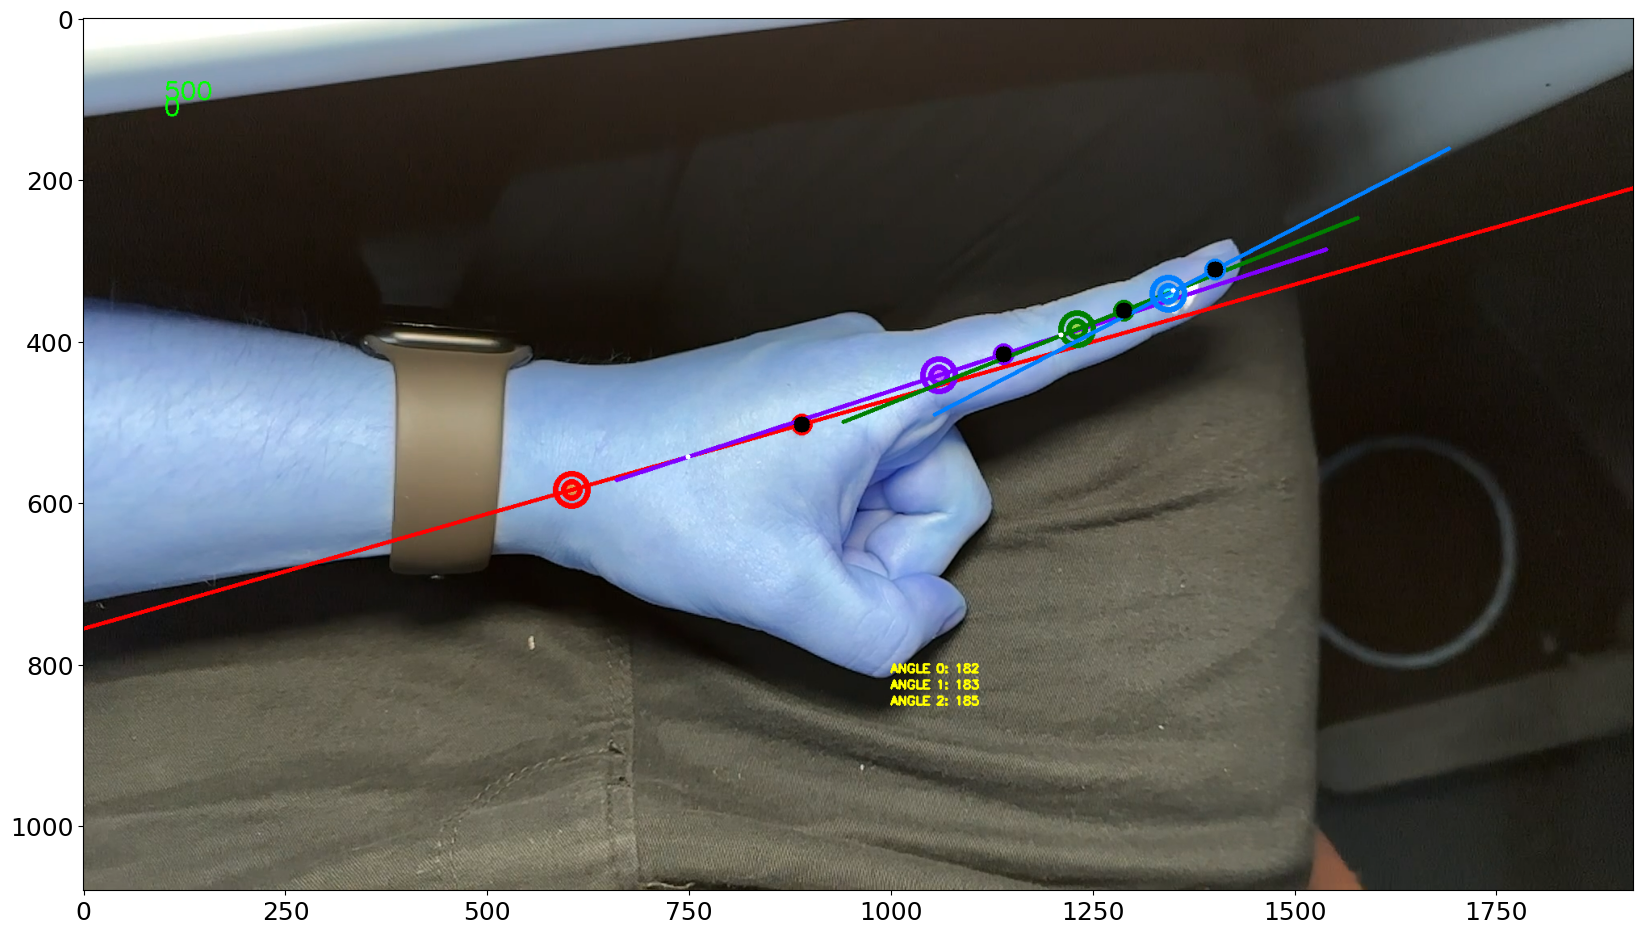

In [224]:
cap = cv2.VideoCapture("../IMG_7102.MOV")
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_shift + 500)
cap.set(cv2.CAP_PROP_FPS, set_fps)
# cap.set(cv2.SET_)
ret, frame = cap.read()

# Use the original frame instead of creating a copy
frame, angle_0, angle_1, angle_2, intersection_point_0, intersection_point_1, intersection_point_2, intersection_point_3  = main_function(frame, False)

# Add text to the frame
frame = add_text_to_frame(frame, str(frame_shift), position=text_position_cnt, font_scale=font_scale)

# Calculate and add time information
end = time.time()
frame = add_text_to_frame(frame, "0", position=text_position_time, font_scale=font_scale)

plt.figure(figsize=(20,20))
plt.imshow(frame)
# measure.append([cnt, angle_0,angle_1,angle_2])

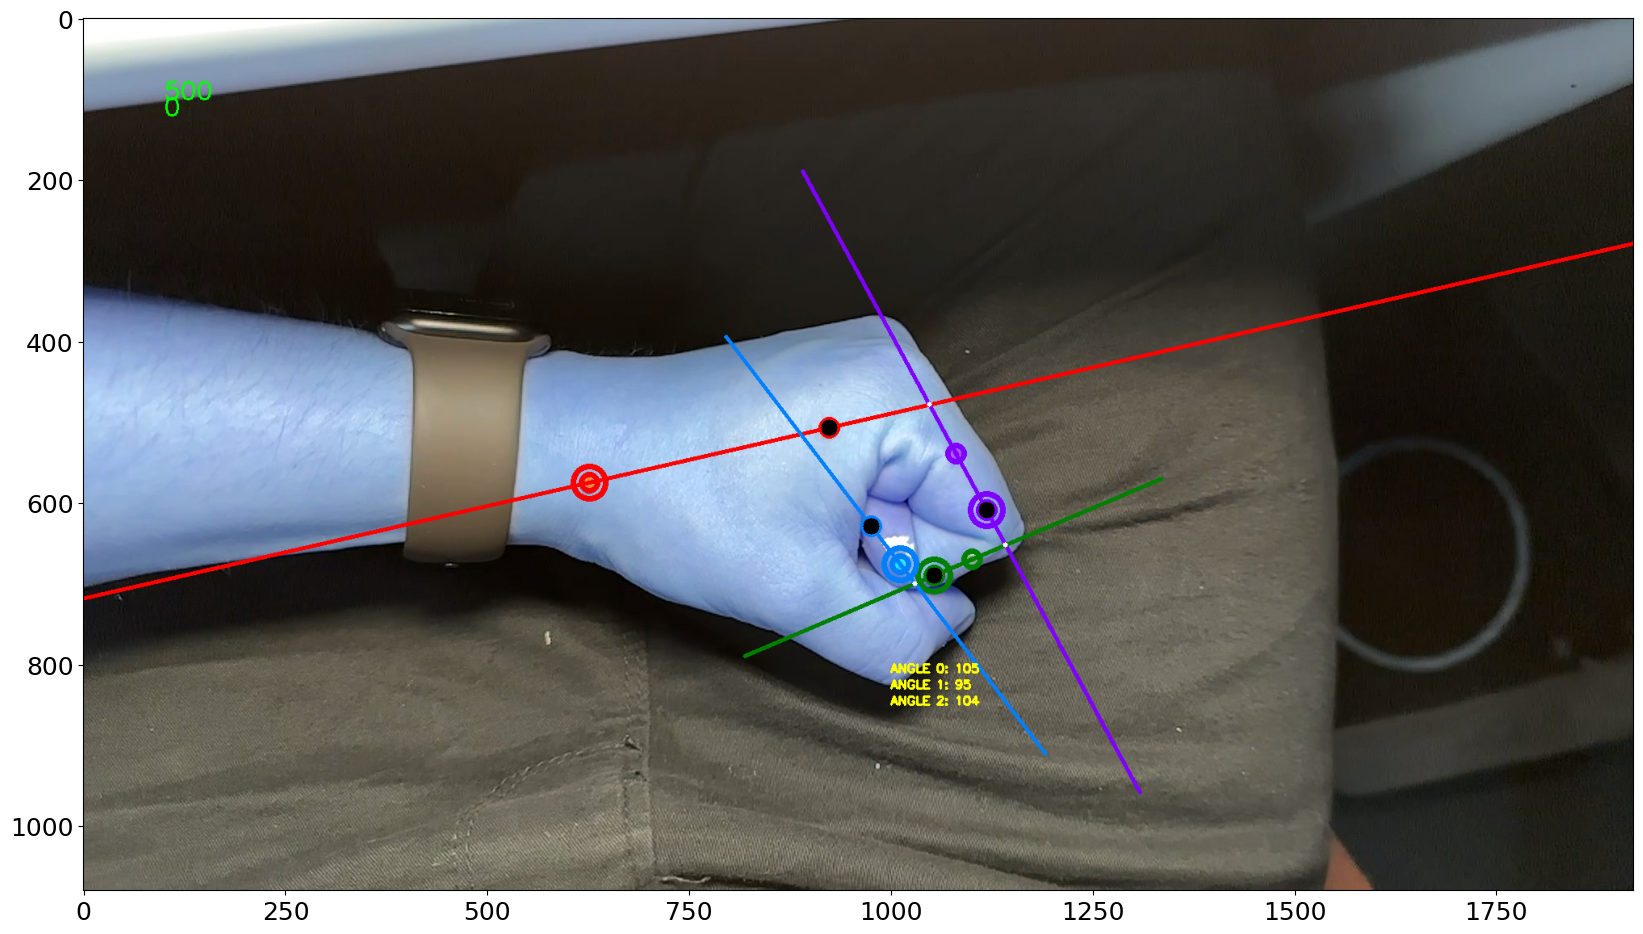

# Main logic

In [223]:
import cv2
import time

# Add the necessary functions for main_function and add_text_to_frame

cap = cv2.VideoCapture("../IMG_7102.MOV")
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_shift)
cap.set(cv2.CAP_PROP_FPS, 130)

if not cap.isOpened():
    print("Error: Could not open the video file.")
    exit()

# Create a window to display the frames
cv2.namedWindow('Video Preview', cv2.WINDOW_NORMAL)

measure = []  # for storing angles
frames_to_store = []
cnt = frame_shift  # for storing frame count
paused = False

while True:
    strt = time.time()

    if not paused:
        ret, frame = cap.read()
        if not ret:
            break

        # Use the original frame instead of creating a copy
        frame, angle_0, angle_1, angle_2, intersection_point_0, intersection_point_1, intersection_point_2, intersection_point_3 = main_function(frame, False)

        # Add text to the frame
        frame = add_text_to_frame(frame, str(cnt), position=text_position_cnt, font_scale=font_scale)

        # Calculate and add time information
        end = time.time()
        frame = add_text_to_frame(frame, str(end - strt), position=text_position_time, font_scale=font_scale)
        measure.append([cnt, angle_0, angle_1, angle_2, intersection_point_0[0], intersection_point_0[1], intersection_point_1[0], intersection_point_1[1], intersection_point_2[0], intersection_point_2[1], intersection_point_3[0], intersection_point_3[1]])

        cv2.imshow('Video Preview', frame)
        frames_to_store.append(frame.copy())
        cnt += 1

    key = cv2.waitKeyEx(1)  # Use cv2.waitKeyEx to capture arrow key presses

    if key == 27:  # Press 'Esc' to exit
        break
    elif key == 32:  # Press 'Space' to pause/unpause
        paused = not paused
    elif key == 97:  # Press left arrow key to move backward
        cap.set(cv2.CAP_PROP_POS_FRAMES, max(0, cnt - 2))
        cnt -= 2
    elif key == 100:  # Press right arrow key to move forward
        cap.set(cv2.CAP_PROP_POS_FRAMES, cnt)
    elif key == 65364:  # Press down arrow key to move forward faster
        cap.set(cv2.CAP_PROP_POS_FRAMES, min(cap.get(cv2.CAP_PROP_FRAME_COUNT) - 1, cnt + 30))
        cnt += 30

cap.release()
cv2.destroyAllWindows()


[ WARN:0@8993.018] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_562_cazh1h/croots/recipe/opencv-suite_1664548333142/work/modules/videoio/src/cap_gstreamer.cpp (2386) handleMessage OpenCV | GStreamer warning: your GStreamer installation is missing a required plugin
[ WARN:0@8993.018] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_562_cazh1h/croots/recipe/opencv-suite_1664548333142/work/modules/videoio/src/cap_gstreamer.cpp (2402) handleMessage OpenCV | GStreamer warning: Embedded video playback halted; module uridecodebin38 reported: Your GStreamer installation is missing a plug-in.
[ WARN:0@8993.018] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_562_cazh1h/croots/recipe/opencv-suite_1664548333142/work/modules/videoio/src/cap_gstreamer.cpp (1356) open OpenCV | GStreamer warning: unable to start pipeline
[ WARN:0@8993.018] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_562_cazh1h/croots/recipe/opencv-s

IndexError: list index out of range

In [194]:
cap.release()
cv2.destroyAllWindows()

## Store processed video

In [195]:
# Store the video with updated frames
output_video_path = os.path.join(output_folder_video,f"{video_name}.mp4")  # Set the desired output video path
store_video(frames_to_store, output_video_path, set_fps)


(<unknown>:43745): GStreamer-CRITICAL **: 02:59:36.112: gst_element_make_from_uri: assertion 'gst_uri_is_valid (uri)' failed
[ WARN:0@8810.756] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_562_cazh1h/croots/recipe/opencv-suite_1664548333142/work/modules/videoio/src/cap_gstreamer.cpp (2180) open OpenCV | GStreamer warning: cannot link elements
2023-12-16 02:59:36.190 python[43745:28634532] AVF: AVAssetWriter status: Cannot Save


## Store csv - raw_angles

In [206]:
df_angle = pd.DataFrame(data=measure, columns=["frame", "angle_0", "angle_1", "angle_2", "i_p_0_x", "i_p_0_y","i_p_1_x", "i_p_1_y","i_p_2_x", "i_p_2_y","i_p_3_x", "i_p_3_y"])
df_angle["time"] = df_angle["frame"] / set_fps
df_angle.to_csv(os.path.join(output_folder_csv,f"{video_name}.csv"), index=False)
df_angle

,frame,angle_0,angle_1,angle_2,i_p_0_x,i_p_0_y,i_p_1_x,i_p_1_y,i_p_2_x,i_p_2_y,i_p_3_x,i_p_3_y,time
0,500,108.411997,95.616618,107.868928,935,458,1143,534,1105,637,1010,610,3.333333
1,501,108.070983,94.565037,109.502839,936,458,1143,534,1105,637,1010,610,3.340000
2,502,108.070983,95.416016,109.118753,936,458,1143,535,1105,638,1010,610,3.346667
3,503,108.132717,95.416016,108.271437,937,458,1143,535,1105,638,1010,610,3.353333
4,504,109.105193,93.530827,109.122416,937,458,1144,535,1105,638,1010,610,3.360000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,1083,192.166393,189.383085,187.626994,884,507,1127,391,1252,306,1340,227,7.220000
584,1084,192.166393,189.383085,186.952957,884,507,1127,391,1252,306,1340,228,7.226667
585,1085,192.220577,187.434327,189.575753,884,507,1126,391,1253,306,1340,227,7.233333
586,1086,192.220577,188.010393,188.325650,884,507,1126,391,1252,306,1340,228,7.240000


In [207]:
select_rows = np.all(np.array([np.all(df_angle[["i_p_0_x", "i_p_1_x", "i_p_2_x", "i_p_3_x"]] < 1920,axis=1),
                 np.all(df_angle[["i_p_0_x", "i_p_1_x", "i_p_2_x", "i_p_3_x"]] > 0, axis=1),
                 np.all(df_angle[["i_p_0_y", "i_p_1_y", "i_p_2_y", "i_p_3_y"]] < 1080,axis=1),
                 np.all(df_angle[["i_p_0_y", "i_p_1_y", "i_p_2_y", "i_p_3_y"]] > 0,axis=1)]),axis=0)

In [218]:
df_angle_filter = df_angle.loc[list(select_rows)]
df_angle_filter = df_angle_filter[400:]

In [219]:
trajectory_points_name = [("i_p_0_x", "i_p_0_y"), ("i_p_1_x", "i_p_1_y"), ("i_p_2_x", "i_p_2_y"), ("i_p_3_x", "i_p_3_y")]

matrix_of_points_trajectory = []
for point_name in trajectory_points_name:
    points = list(zip(df_angle_filter[point_name[0]], df_angle_filter[point_name[1]]))
    # Find the minimum and maximum X and Y coordinates
    # min_x = min(df_angle_filter["i_p_1_x"])
    # max_x = max(df_angle_filter["i_p_1_x"])
    # min_y = min(df_angle_filter["i_p_1_y"])
    # max_y = max(df_angle_filter["i_p_1_y"])
    # print(min_x,max_x,min_y,max_y)

    # Create a matrix with zeros
    matrix = np.zeros((1080,1920), dtype=int)

    # Fill the matrix with the points
    for x, y in points:
        matrix[y , x] = 1  # Adjust indices to fit within the matrix

    matrix_of_points_trajectory.append(matrix)



Text(0.5, 1.0, 'b')

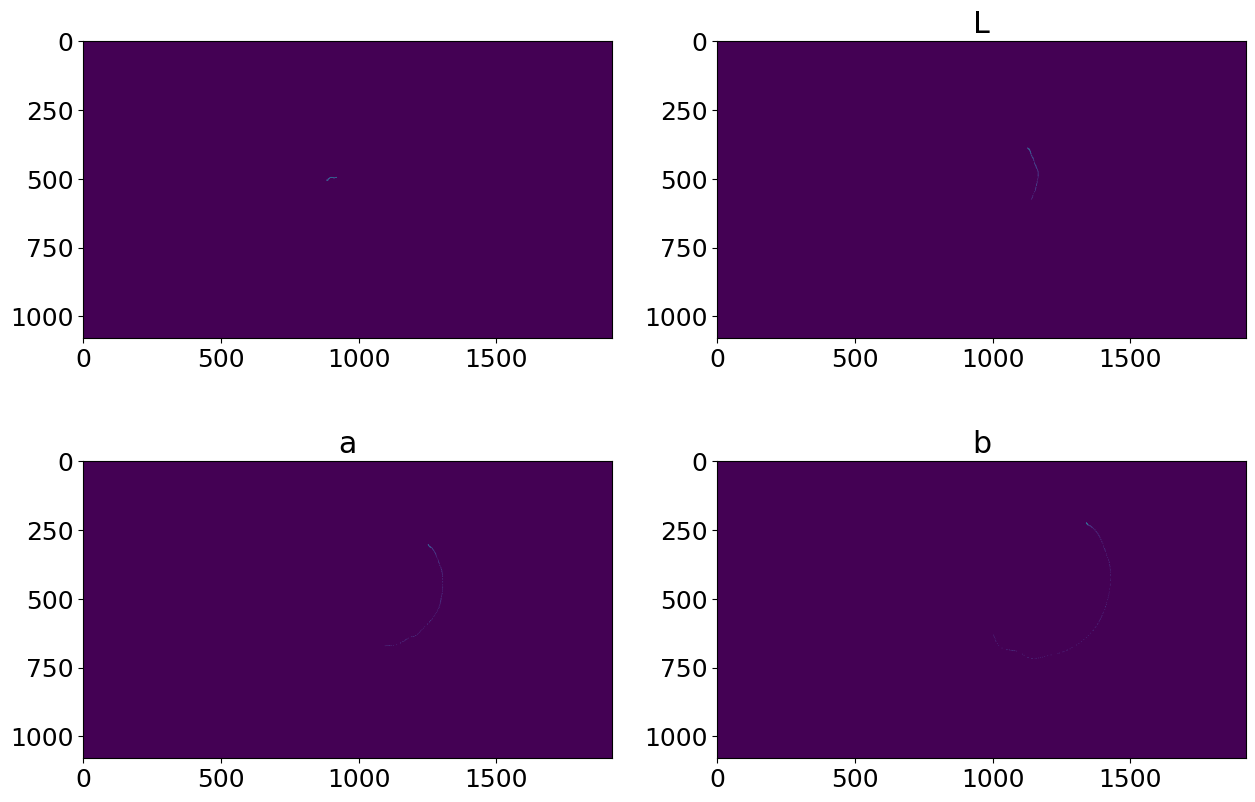

In [220]:
plt.figure(figsize= (15, 10))
plt.rcParams['font.size']=18
plt.subplot(221)
plt.imshow(matrix_of_points_trajectory[0]>0)
plt.subplot(222)
plt.imshow(matrix_of_points_trajectory[1]>0)
# plt.colorbar()
plt.title('L')
plt.subplot(223)
plt.imshow(matrix_of_points_trajectory[2]>0)
# plt.colorbar()
plt.title('a')
plt.subplot(224)
plt.imshow(matrix_of_points_trajectory[3]>0)
# plt.colorbar()
plt.title('b')

In [221]:
colors

[(255, 0, 0), (127, 0, 255), (0, 127, 0), (0, 127, 255)]

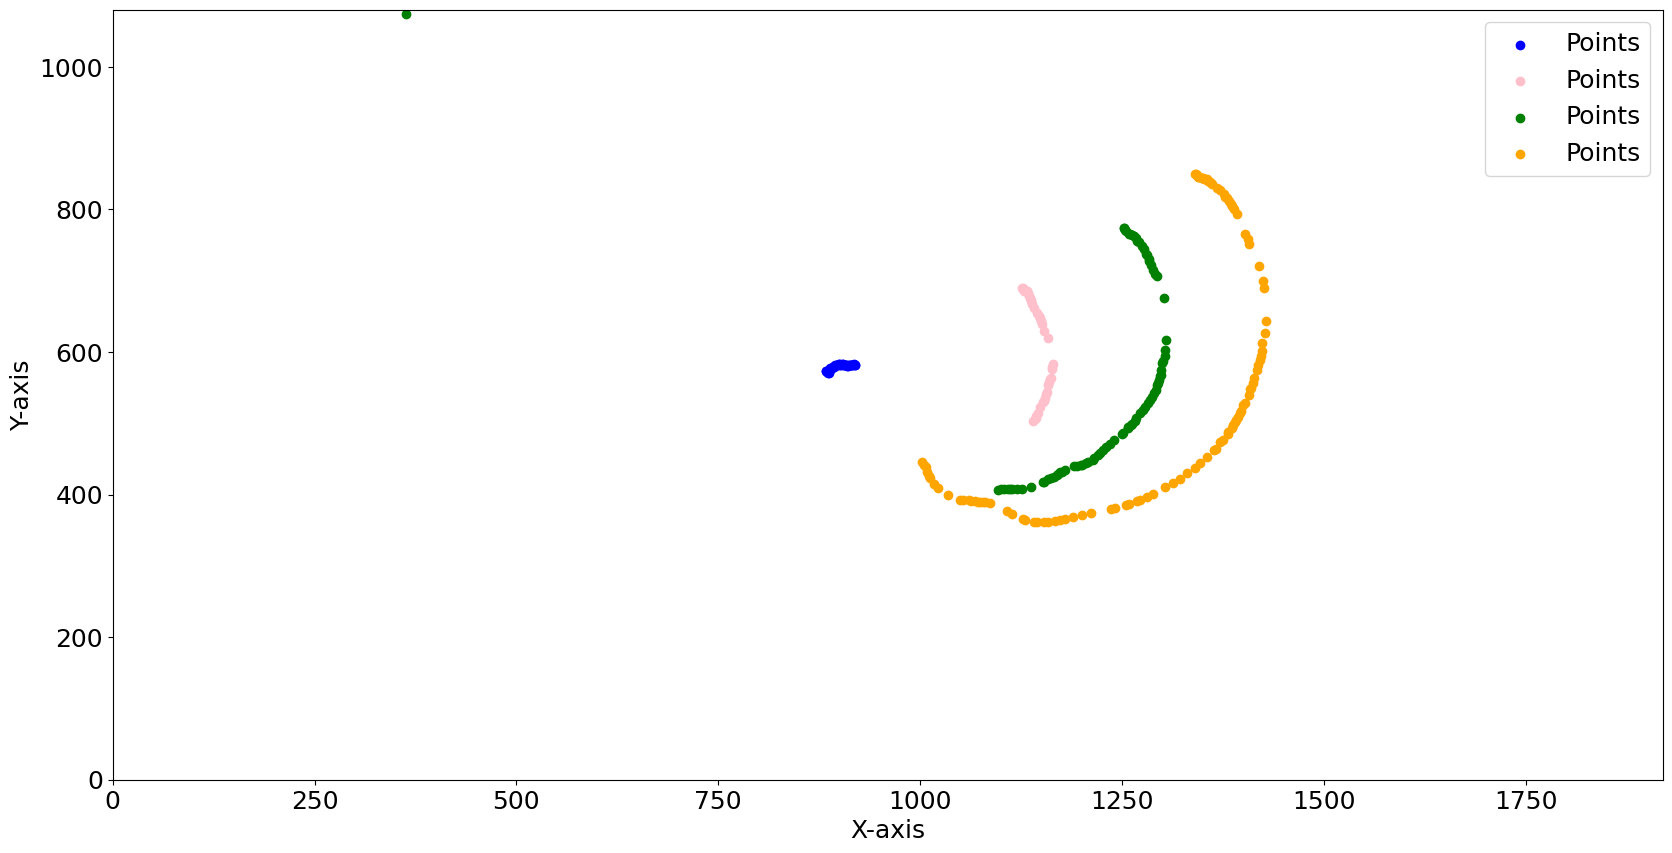

In [222]:
# Create a curve using numpy's polyfit function
degree = 4  # You can adjust the degree of the polynomial
from scipy.interpolate import interp1d
colorss = ["blue", "pink", "green", "orange"]
plt.figure(figsize=(20,10))
for index in range(0,len(trajectory_points_name)):
    pp = trajectory_points_name[index]

    unique_indices = np.unique(df_angle_filter[pp[0]], return_index=True)[1]
    # Create a cubic spline interpolation

    x_points_unique = (np.array(df_angle_filter[pp[0]])[unique_indices])
    y_points_unique = (np.array(df_angle_filter[pp[1]])[unique_indices]- 1080) * -1

    # Create a cubic spline interpolation
    spline_interp = interp1d(x_points_unique, y_points_unique, kind='cubic')

    # Define the range for the curve within the existing points
    x_min, x_max = min(x_points_unique), max(x_points_unique)

    # Generate x values for the curve within the specified range
    x_curve = np.linspace(x_min, x_max, 3)



    # Plot the points and the curve
    plt.scatter(x_points_unique, y_points_unique, label='Points', color=colorss[index])
    # plt.plot(x_curve, spline_interp(x_curve), label='Cubic Spline', color='red')

# Add labels and legend
plt.xlim(0, 1920)
plt.ylim(0, 1080)
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()

# Show the plot
plt.show()

In [166]:
df_angle_filter[pp[0]]

400    1003
401    1005
402    1007
403    1009
404    1011
       ... 
583    1340
584    1340
585    1340
586    1340
587    1340
Name: i_p_3_x, Length: 188, dtype: int64

In [167]:
unique_indices

array([  0,   1,   2,   3,   4,   5,   6,   7,   9,  11,  12,  13,  14,
        15,  16,  17,  18,  19,  20,  22,  23,  24,  25,  26,  27,  28,
        29,  31,  32,  33,  34,  35,  36,  38,  39,  40,  41,  42,  43,
        44,  45,  47,  48,  49,  50,  51, 175, 169, 166, 162, 160, 158,
        52, 156, 155, 153, 151, 149,  54, 102, 100, 143,  95,  93,  56,
        57, 139, 138,  58,  59, 134, 132, 131,  60,  61, 129, 128,  62,
       126,  63, 125,  64,  65, 123,  66,  67,  68,  69,  70, 115, 113,
        72, 111,  74,  75,  76,  77,  79,  80,  81,  82,  83,  85,  87,
        89])

1064 1165 391 577


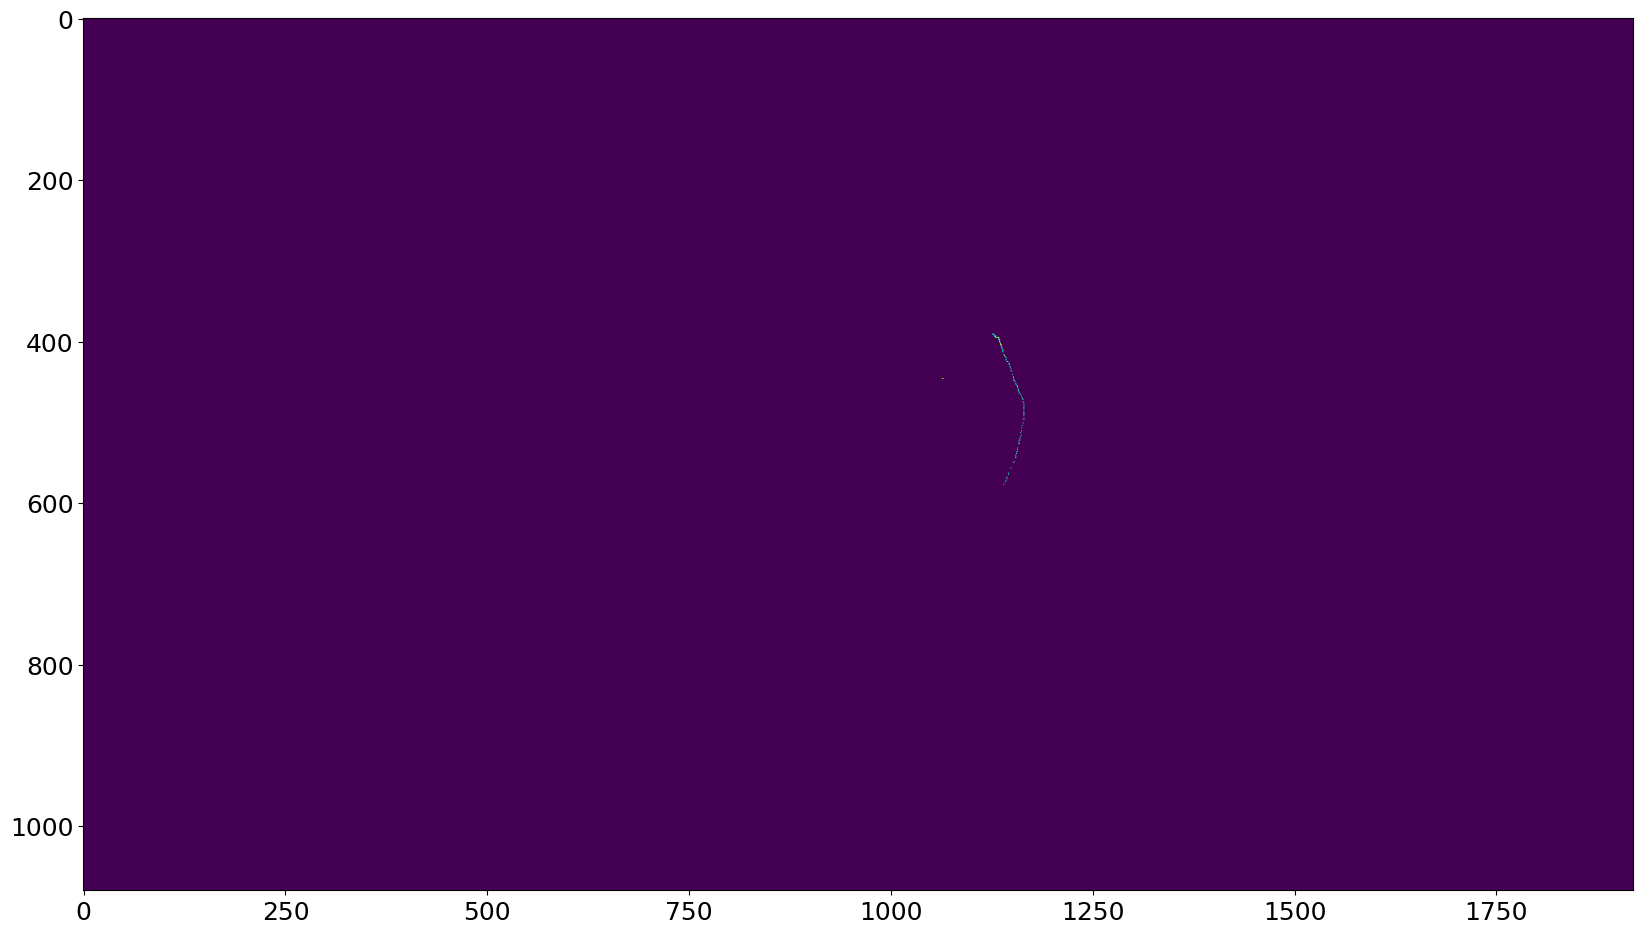

In [46]:
# Combine X and Y coordinates into a list of points
points = list(zip(df_angle_filter["i_p_1_x"], df_angle_filter["i_p_1_y"]))

# Find the minimum and maximum X and Y coordinates
min_x = min(df_angle_filter["i_p_1_x"])
max_x = max(df_angle_filter["i_p_1_x"])
min_y = min(df_angle_filter["i_p_1_y"])
max_y = max(df_angle_filter["i_p_1_y"])
print(min_x,max_x,min_y,max_y)

# Create a matrix with zeros
matrix = np.zeros((max_y - min_y + 1, max_x - min_x + 1), dtype=int)

# Fill the matrix with the points
for x, y in points:
    matrix[y - min_y, x - min_x] = 1  # Adjust indices to fit within the matrix
# Create a matrix with zeros
matrix = np.zeros((1080,1920), dtype=int)

# Fill the matrix with the points
for x, y in points:
    matrix[y , x] = 1  # Adjust indices to fit within the matrix

# # Print the matrix
# print(matrix)
plt.figure(figsize=(20,20))
plt.imshow(matrix>0)
# # Print the matrix
# print(matrix)

605 920 497 584


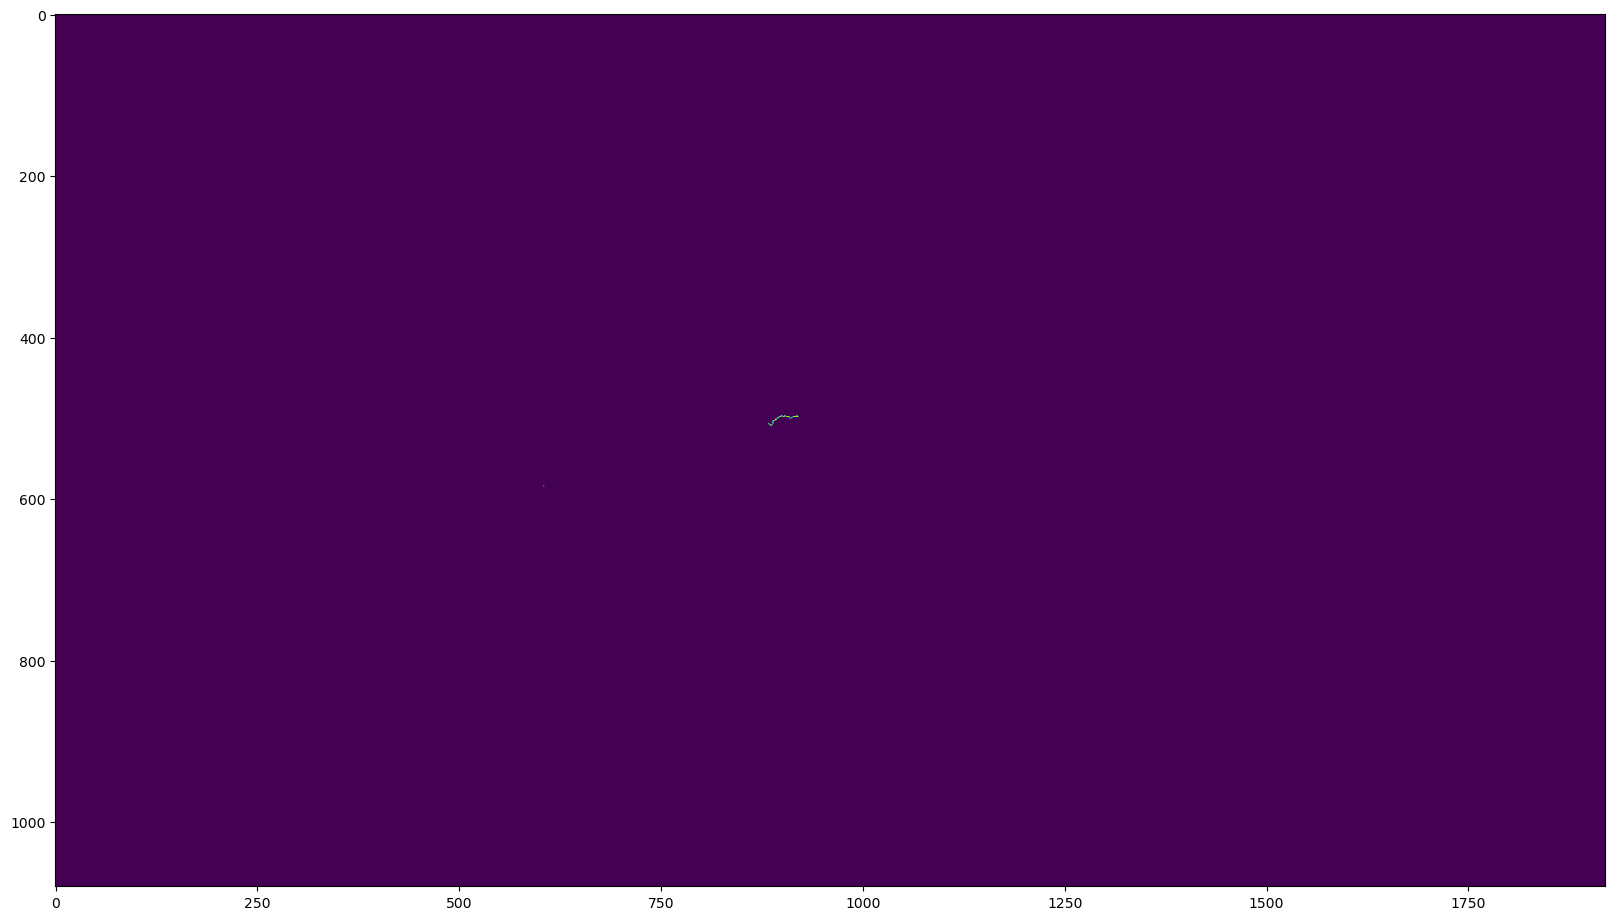

In [30]:
# Combine X and Y coordinates into a list of points
points = list(zip(df_angle_filter["i_p_0_x"], df_angle_filter["i_p_0_y"]))

# Find the minimum and maximum X and Y coordinates
min_x = min(df_angle_filter["i_p_0_x"])
max_x = max(df_angle_filter["i_p_0_x"])
min_y = min(df_angle_filter["i_p_0_y"])
max_y = max(df_angle_filter["i_p_0_y"])
print(min_x,max_x,min_y,max_y)

# Create a matrix with zeros
matrix = np.zeros((1080,1920), dtype=int)

# Fill the matrix with the points
for x, y in points:
    matrix[y , x] = 1  # Adjust indices to fit within the matrix

# # Print the matrix
# print(matrix)
plt.figure(figsize=(20,20))
plt.imshow(matrix)

1003 1428 226 719


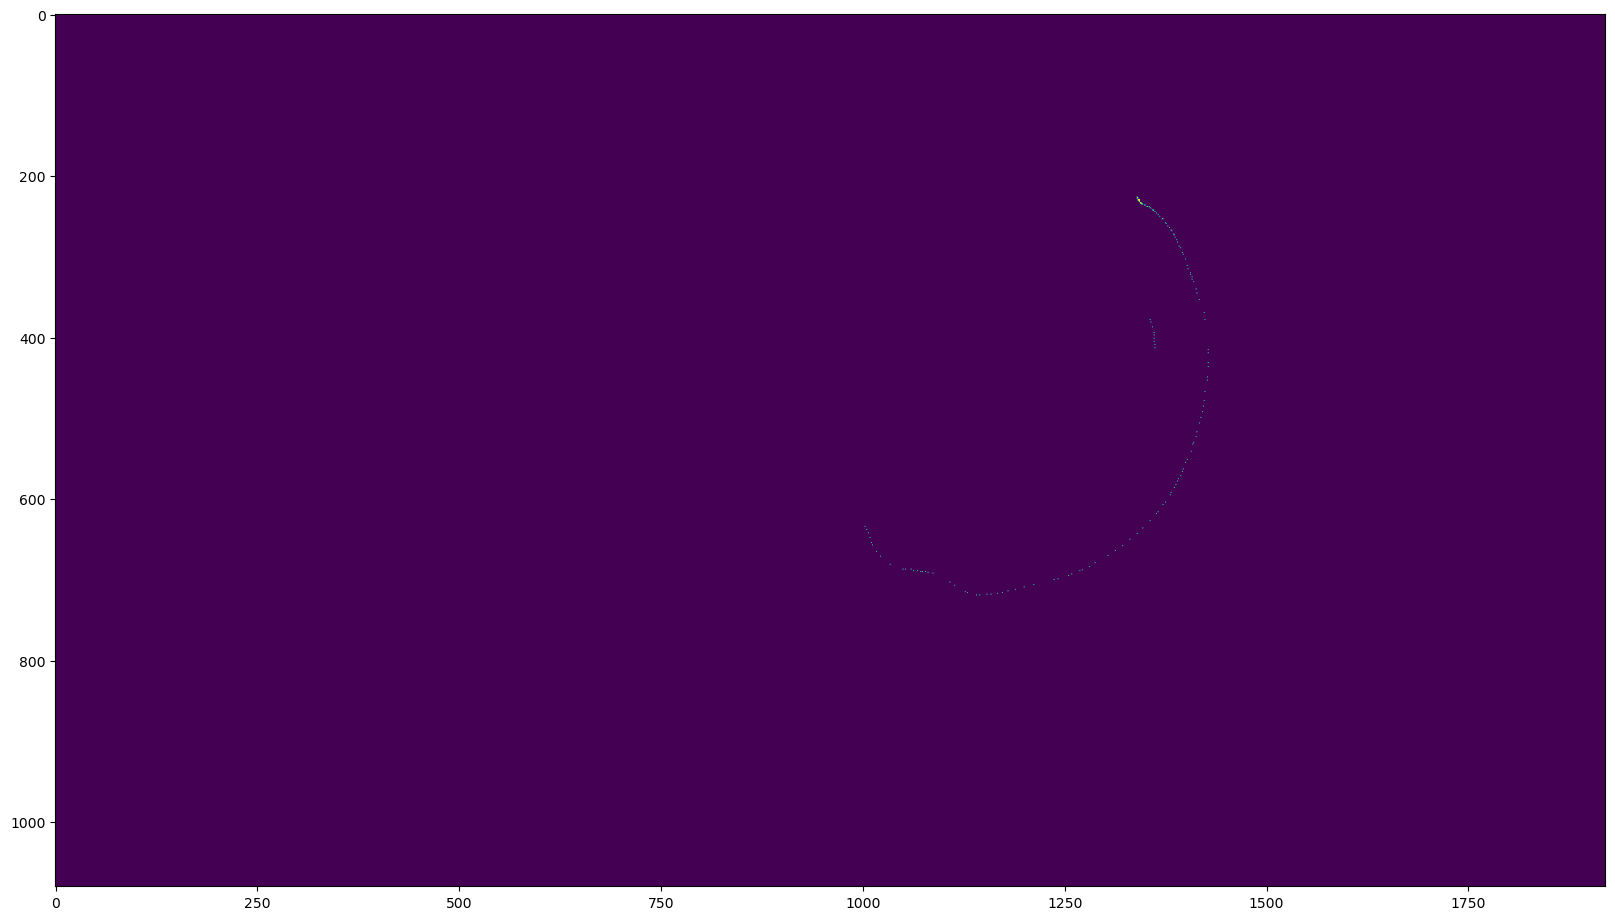

In [31]:
# Combine X and Y coordinates into a list of points
points = list(zip(df_angle_filter["i_p_3_x"], df_angle_filter["i_p_3_y"]))

# Find the minimum and maximum X and Y coordinates
min_x = min(df_angle_filter["i_p_3_x"])
max_x = max(df_angle_filter["i_p_3_x"])
min_y = min(df_angle_filter["i_p_3_y"])
max_y = max(df_angle_filter["i_p_3_y"])
print(min_x,max_x,min_y,max_y)

# Create a matrix with zeros
matrix = np.zeros((1080,1920), dtype=int)

# Fill the matrix with the points
for x, y in points:
    matrix[y , x] = 1  # Adjust indices to fit within the matrix

# # Print the matrix
# print(matrix)
plt.figure(figsize=(20,20))
plt.imshow(matrix)

1064 1165 391 577


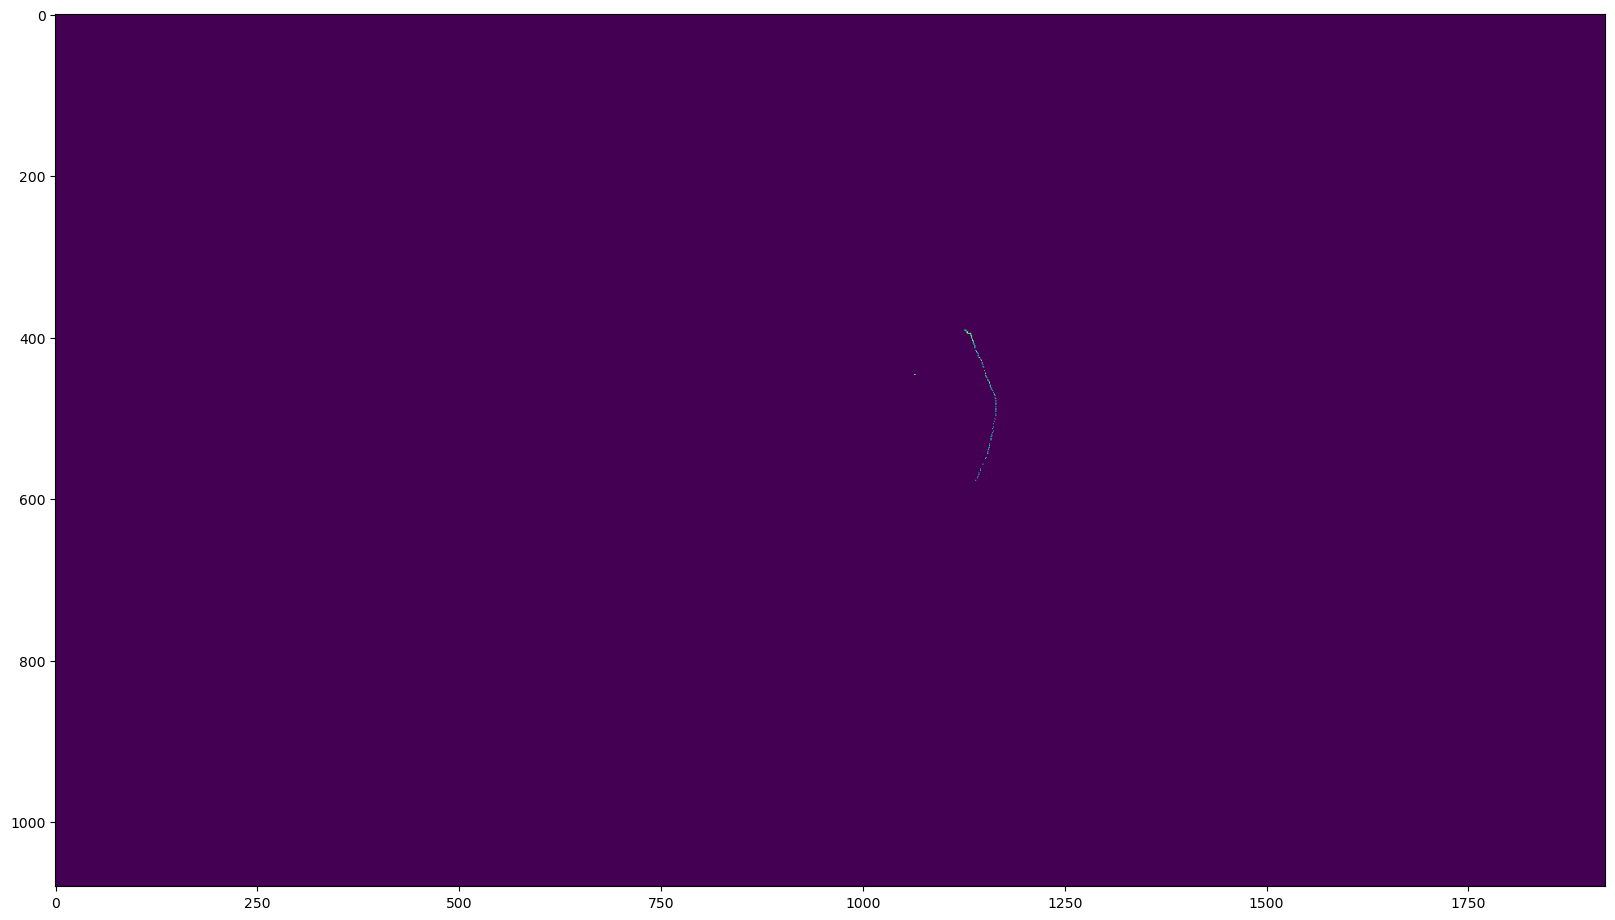

In [32]:
# Combine X and Y coordinates into a list of points
points = list(zip(df_angle_filter["i_p_1_x"], df_angle_filter["i_p_1_y"]))

# Find the minimum and maximum X and Y coordinates
min_x = min(df_angle_filter["i_p_1_x"])
max_x = max(df_angle_filter["i_p_1_x"])
min_y = min(df_angle_filter["i_p_1_y"])
max_y = max(df_angle_filter["i_p_1_y"])
print(min_x,max_x,min_y,max_y)

# Create a matrix with zeros
matrix = np.zeros((1080,1920), dtype=int)

# Fill the matrix with the points
for x, y in points:
    matrix[y , x] = 1  # Adjust indices to fit within the matrix

# # Print the matrix
# print(matrix)
plt.figure(figsize=(20,20))
plt.imshow(matrix)

1096 1305 306 673


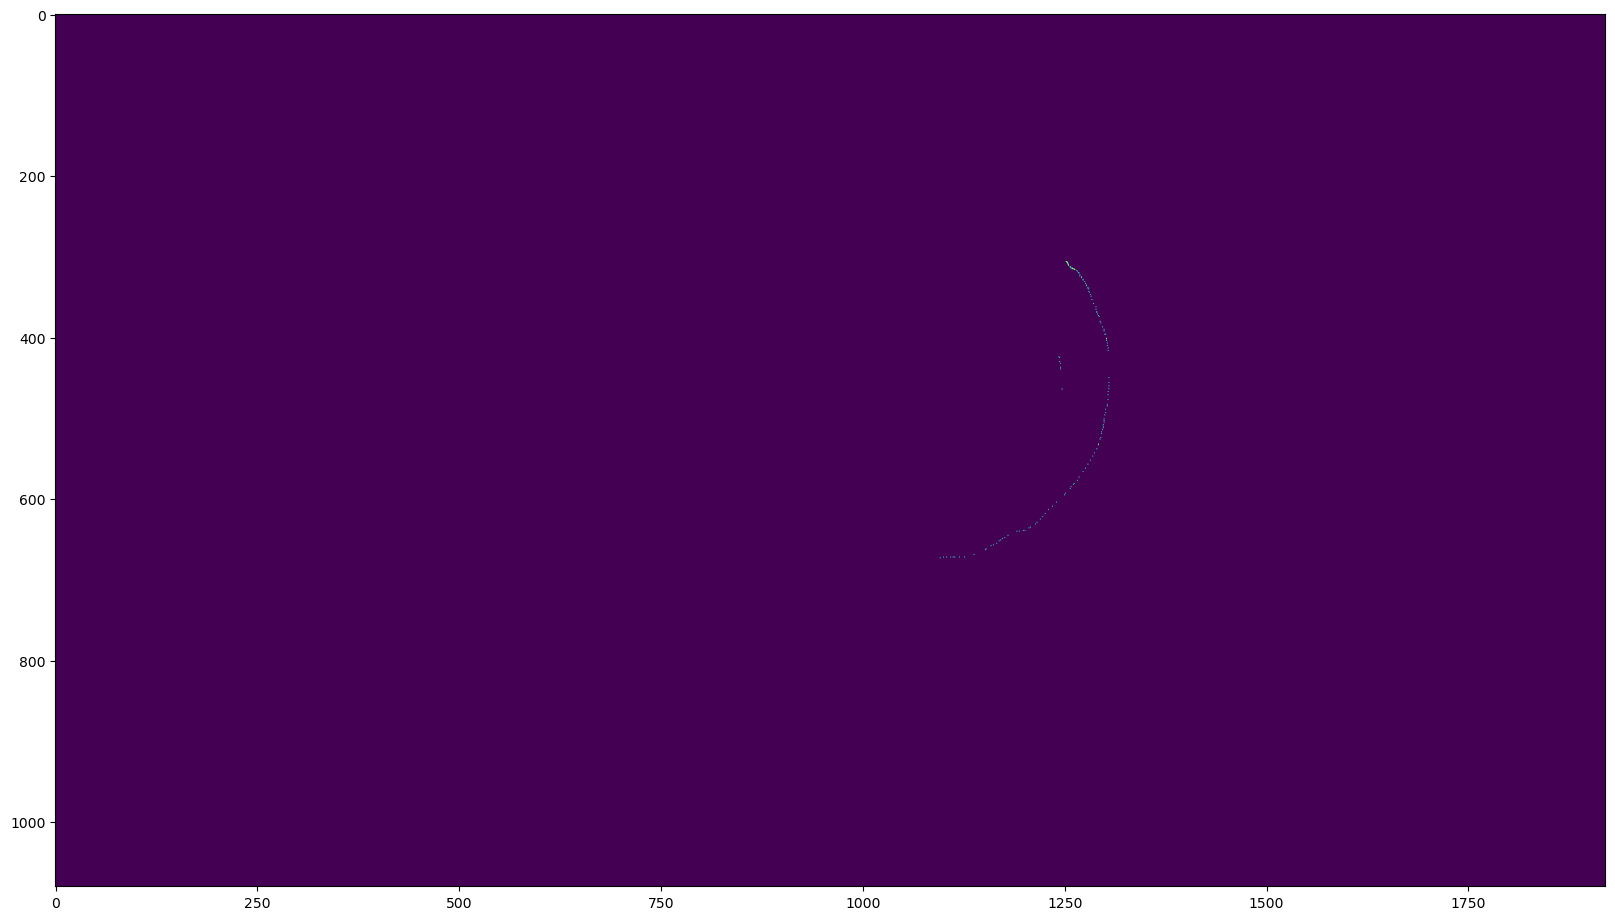

In [33]:
# Combine X and Y coordinates into a list of points
points = list(zip(df_angle_filter["i_p_2_x"], df_angle_filter["i_p_2_y"]))

# Find the minimum and maximum X and Y coordinates
min_x = min(df_angle_filter["i_p_2_x"])
max_x = max(df_angle_filter["i_p_2_x"])
min_y = min(df_angle_filter["i_p_2_y"])
max_y = max(df_angle_filter["i_p_2_y"])
print(min_x,max_x,min_y,max_y)

# Create a matrix with zeros
matrix = np.zeros((1080,1920), dtype=int)

# Fill the matrix with the points
for x, y in points:
    matrix[y , x] = 1  # Adjust indices to fit within the matrix

# # Print the matrix
# print(matrix)
plt.figure(figsize=(20,20))
plt.imshow(matrix)